In [10]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betatcvae import BetaTCVAE, compile_vae, weights
from optimize_utils_tcvae import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [11]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True, adult_or_ped="all"
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [12]:
# Load the best hyperparameters
study_name = "BetaTCVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [13]:
#Initialize the model and optimizer
model = BetaTCVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 393.18384372084887, Val Loss: 106.1517842610677, Test Loss: 107.18848164876302
Epoch 2, Train Loss: 56.06574470178405, Val Loss: 63.33672078450521, Test Loss: 63.9453854031033
Epoch 3, Train Loss: 44.37765794440882, Val Loss: 56.747613271077476, Test Loss: 57.53612942165799
Epoch 4, Train Loss: 46.15758876515858, Val Loss: 51.4575441148546, Test Loss: 52.47448942396376
Epoch 5, Train Loss: 48.191906647184005, Val Loss: 48.28012254503038, Test Loss: 49.274464501274956
Epoch 6, Train Loss: 46.97615985016325, Val Loss: 46.017278883192276, Test Loss: 46.85972256130643
Epoch 7, Train Loss: 44.867177297108206, Val Loss: 44.54966481526693, Test Loss: 45.40625508626302
Epoch 8, Train Loss: 43.89649375801656, Val Loss: 43.3391842312283, Test Loss: 44.05809020996094
Epoch 9, Train Loss: 42.541650117333255, Val Loss: 42.58659574720595, Test Loss: 43.343868255615234
Epoch 10, Train Loss: 42.471825898583255, Val Loss: 41.89152696397569, Test Loss: 42.47844229804145
Epoch 11, Tr

In [14]:
# Save the model
model_path = pathlib.Path("results/best_tc_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [15]:
# Save training history
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

history_path = pathlib.Path("results/tc_training_history.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

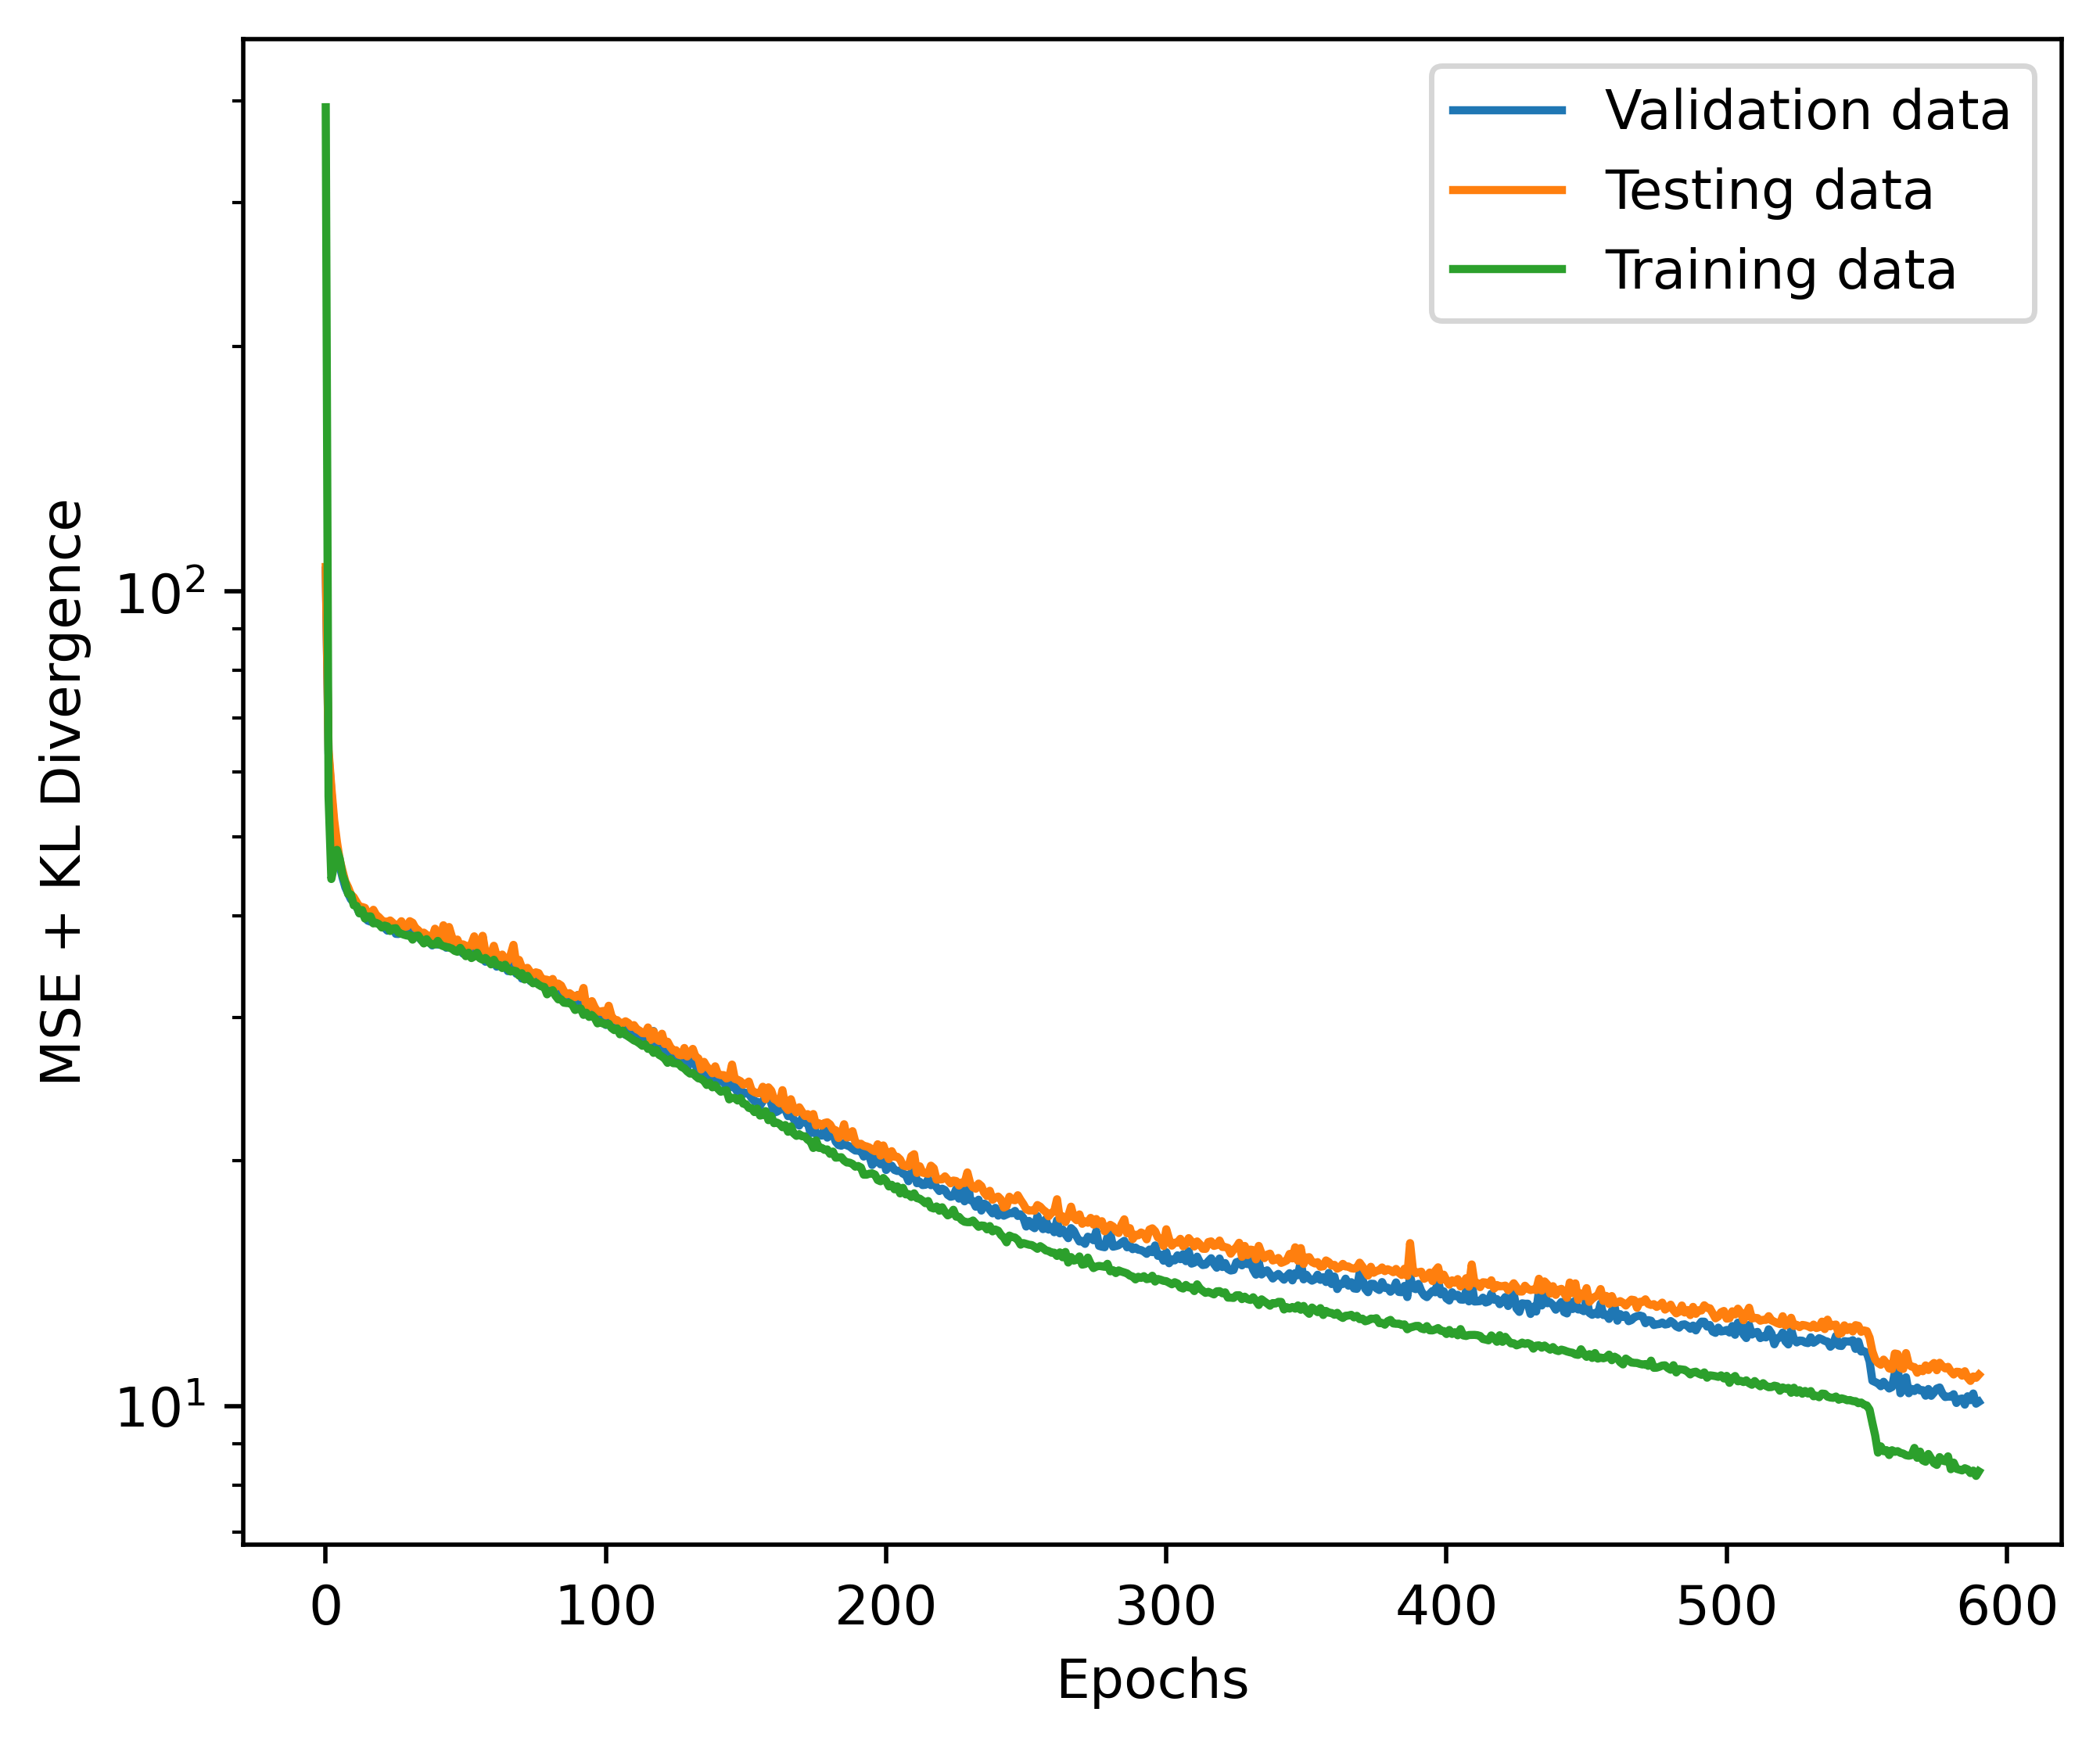

In [16]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

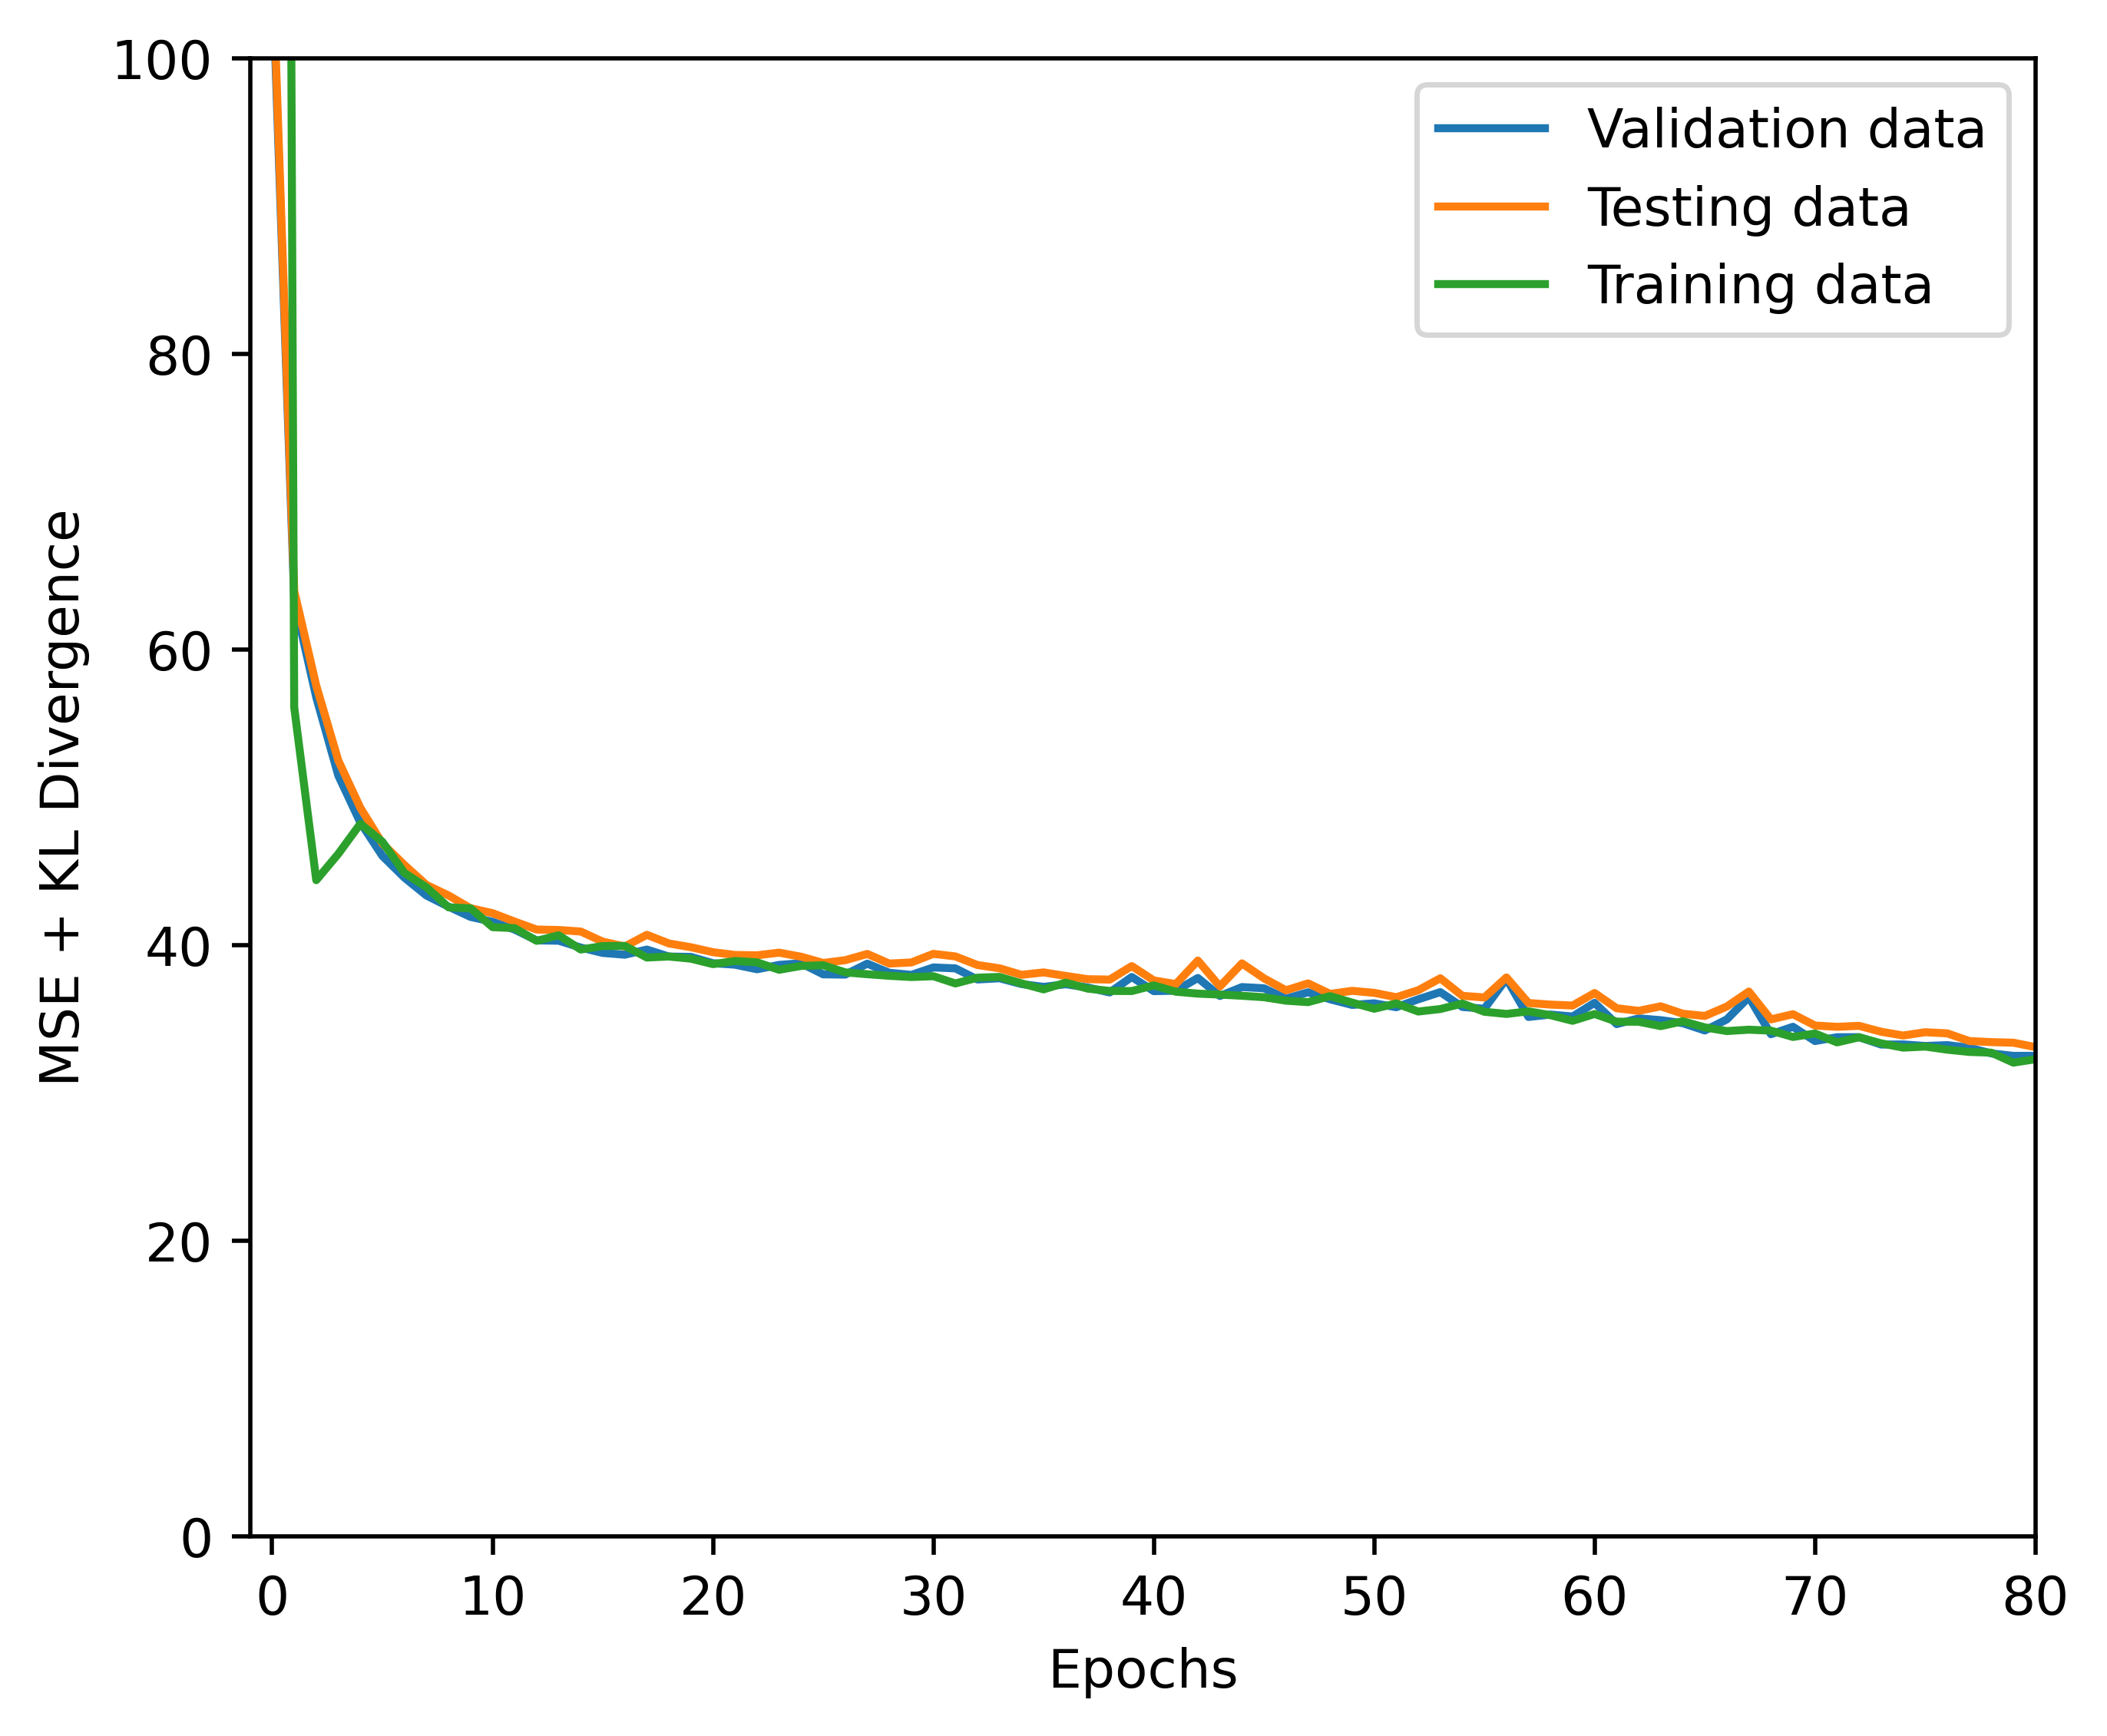

In [17]:
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,80)
plt.ylim(0,100)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [18]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train", drop_columns=False
)

train_df[["AgeCategory", "Sex"]] = train_df.age_and_sex.str.split(
    pat="_", expand=True
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data)
# Save as parquet to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea_tc.parquet")
final_gene_weights_df.to_parquet(gene_weight_dir, index=False) 